In [24]:
import pandas as pd
import xgboost as xgb
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib widget

<h1 style='text-align:center'>Dataset Loading and Preprocessing</h1>

In [4]:
def categorical_to_numeric(df, column, mapping, regex=False):
    df[column] = df[column].replace(mapping, regex=regex)


def load_preprocess(dataset_dir="input/telomere_health.csv"):
    data_raw = pd.read_csv(dataset_dir)
    data_cleaned = data_raw.drop(
        columns=[
            "marital_status",
            "education_cohort",
            "socioeconomic_status",
            "bmi_category",
            "bp",
            "hr_category",
            "rr_category",
            "health_condition",
        ]
    )

    categorical_to_numeric(
        data_cleaned,
        "cigarette_smoking",
        {
            "No information": np.nan,
            "Former Smoker": np.nan,
            "Never Smoker": 0,
            "Occasional Smoker": 1,
            "Regular Smoker": 2,
        },
    )

    categorical_to_numeric(
        data_cleaned,
        "physical_activity_cohort",
        {
            "No information": np.nan,
            "Sedentary (Inactive)": 0,
            "Minimally Active": 1,
            "Lightly Active": 2,
            "Moderately Active": 3,
            "Highly Active": 4,
        },
    )

    categorical_to_numeric(
        data_cleaned,
        "alcohol_drinking",
        {
            "No information": np.nan,
            "Former Drinker": np.nan,
            "Never Drinker": 0,
            "Occasional Drinker": 1,
            "Moderate Drinker": 2,
            "Heavy Drinker": 3,
        },
    )

    categorical_to_numeric(
        data_cleaned,
        "bp_category",
        {
            "No information": np.nan,
            "Hypotension (Low BP)": 0,
            "Normal BP": 1,
            "Elevated BP": 2,
            "Hypertension Stage 1": 3,
            "Hypertension Stage 2": 4,
            "Hypertensive Crisis": 5,
        },
    )

    categorical_to_numeric(
        data_cleaned,
        "cardiovascular_disease_diagnosis",
        {
            "^No known*": 0,
            "^Non-cardiovascular*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "cancer_diagnosis",
        {
            "^Clinically Healthy*": 0,
            "^Non-oncologic*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "depression_anxiety_diagnosis",
        {
            "^No Known*": 0,
            "^Anxiety and/or*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "allergy_diagnosis",
        {
            "^No Diagnosed*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "diabetes_diagnosis",
        {
            "^No known diagnosis*": 0,
            "^Diagnosed with*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "sex",
        {
            "^Female": 0,
            "^Male": 1,
        },
        regex=True,
    )

    data_cleaned["hr"] = pd.to_numeric(data_cleaned["hr"], errors="coerce")
    data_cleaned["rr"] = pd.to_numeric(data_cleaned["rr"], errors="coerce")

    return data_cleaned

<h1 style='text-align:center'>Model Training</h1>

In [25]:
def train_model(data, to_predict, rs=12213594):
    y = data.pop(to_predict)
    X = data

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=rs
    )

    pipeline = Pipeline(
        [
            ("selector", SelectFromModel(estimator=RandomForestClassifier())),
            ("scaler", StandardScaler()),
            ("xgb", xgb.XGBClassifier(objective="binary:logistic")),
        ]
    )

    # preprocessing_pipeline = Pipeline(pipeline.steps[:-1])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    selector = pipeline.named_steps["selector"]
    selected_features = selector.get_support()
    feature_names = X_train.columns[selected_features]

    cv_score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="accuracy")
    confusion_matrix_plot = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    xgb_tree_plot = xgb.plot_tree(pipeline.named_steps["xgb"], numtrees=0)

    return confusion_matrix_plot, xgb_tree_plot, feature_names, cv_score

C:\Users\joshua\AppData\Local\Temp\ipykernel_17436\4034625128.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(mapping, regex=regex)


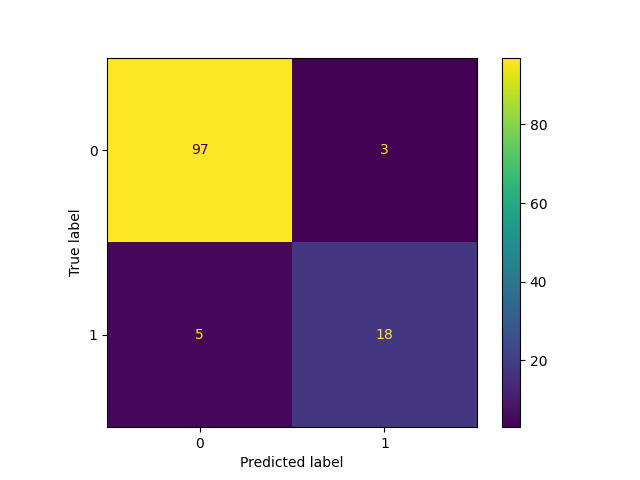

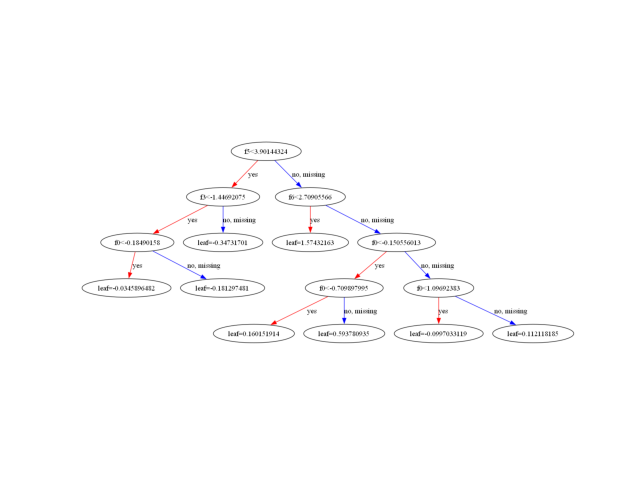

In [27]:
telomere_health_data = load_preprocess()
cf, t, f, cv = train_model(telomere_health_data, "cancer_diagnosis")

In [34]:
for n, i in enumerate(f):
    print(n, i)

0 telomere_length
1 age
2 bmi
3 hr
4 rr
5 bp_category
6 depression_anxiety_diagnosis


In [ ]:
print(cv.mean() * 100)

94.7142857142857


In [33]:
print(cv.std())

0.027686138813174
